<a href="https://colab.research.google.com/github/pablo-arantes/Making-it-rain/blob/main/Amber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Molecular Dynamics (MD) simulations using OpenMM engine and AMBER force field for **PROTEIN** systems. This notebook is a supplementary material of the paper "***Making it rain: Cloud-based molecular simulations for everyone***" (link here) and we encourage you to read it before using this pipeline.

The main goal of this notebook is to demonstrate how to harness the power of cloud-computing to run microsecond-long MD simulations in a cheap and yet feasible fashion.

---

 **This notebook is NOT a standard protocol for MD simulations!** It is just simple MD pipeline illustrating each step of a simulation protocol.

--- 
**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/pablo-arantes/Making-it-rain/issues

**Acknowledgments**
- We would like to thank the OpenMM team for developing an excellent and open source engine. 

- A RAIN by **Pablo R. Arantes** ([@pablitoarantes](https://twitter.com/pablitoarantes)), **Marcelo D. Polêto** ([@mdpoleto](https://twitter.com/mdpoleto)), **Conrado Pedebos** ([@ConradoPedebos](https://twitter.com/ConradoPedebos)) and **Rodrigo Ligabue-Braun** ([@ligabue_braun](https://twitter.com/ligabue_braun)).


- Also, credit to [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin.

- For related notebooks see: [Making-it-rain](https://github.com/pablo-arantes/Making-it-rain)

# **Introduction**

In general, MD simulations rely on 1) a set of atomic coordinates of all atoms on a simulation box and 2) a set of force field parameters that describes the interaction energies between atoms.

In terms of AMBER inputs, we wil need:
*  A PDB ID or a .pdb file containing a set of atomic coordinates of your protein.

In this notebook, we will simulate PDB 1AKI, a hen egg-white lysozyme. To build our simulation box, we will use LEaP program (https://ambermd.org/tutorials/pengfei/index.php). The LEaP program is a portal between many chemical structure file types (.pdb and .mol2, primarily), and the Amber model parameter file types such as .lib, .prepi, parm.dat, and .frcmod. Each of the parameter files contains pieces of information needed for constructing a simulation, whether for energy minimization or molecular dynamics. LEaP functions within a larger workflow described in Section 1.1 of the [Amber Manual](https://ambermd.org/doc12/Amber20.pdf);.
## ---







---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)

In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait. ;-)
# install dependencies
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install biopandas 2>&1 1>/dev/null
# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null
#load dependencies
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from biopandas.pdb import PandasPdb
import simtk.openmm as mm
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
from __future__ import print_function
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')
plt.figure(figsize=(5,7))

<Figure size 360x504 with 0 Axes>

<Figure size 360x504 with 0 Axes>

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug  6 08:05:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
---
# **Loading the necessary input files**

At this point, we should have all libraries and dependencies installed and all necessary input files already at your Google Drive folder.

**Important**: We have 2 cells below, if we want to use PDB ID as an input structure to run the MD simuatons, we should fill and run only the first cell. In the other hand, if we want to use our own protein structure, we should upload the PDB file to the correct pathway and run only the second cell. Make sure the PDB file points to the correct pathway. If necessary, correct the pathway and re-upload the files.



Below, you should provide the names of all input files and the pathway of your Google Drive folder containing them.


In [ ]:
#@title **If you want to use the PDB ID, please, provide the necessary input below:** 
Query_PDB_ID = '1AKI' #@param {type:"string"}
query_PDB = Query_PDB_ID
Google_Drive_Path = '/content/drive/MyDrive/Colab_OpenMM/long_run' #@param {type:"string"}
workDir = Google_Drive_Path 
starting = os.path.join(workDir, "starting.pdb")
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS.prmtop")
crd = os.path.join(workDir, "SYS.crd")
pdb = os.path.join(workDir, "SYS.pdb")

pdbfn = query_PDB + ".pdb"
url = 'https://files.rcsb.org/download/' + pdbfn
outfnm = os.path.join(workDir, pdbfn)
urllib.request.urlretrieve(url, outfnm)
ppdb = PandasPdb().read_pdb(outfnm)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

#@markdown **ATTENTION**: If you ran the present cell, you can ignore the next step.


#@markdown ---

In [ ]:
#@title **If you want to use your own structure, please, provide the necessary input file below:** 
PDB_file_name = 'start.pdb' #@param {type:"string"}
file_name = PDB_file_name
Google_Drive_Path = '/content/drive/MyDrive/Colab_OpenMM/New_test_start' #@param {type:"string"}
workDir = Google_Drive_Path
initial_pdb = os.path.join(workDir, str(file_name))
starting = os.path.join(workDir, "starting.pdb")
tleap = os.path.join(workDir, "tleap.in")
top_nw = os.path.join(workDir, "SYS_nw.prmtop")
crd_nw = os.path.join(workDir, "SYS_nw.crd")
pdb_nw = os.path.join(workDir, "SYS_nw.pdb")
top = os.path.join(workDir, "SYS.prmtop")
crd = os.path.join(workDir, "SYS.crd")
pdb = os.path.join(workDir, "SYS.pdb")

ppdb = PandasPdb().read_pdb(initial_pdb)
ppdb.df['ATOM'] = ppdb.df['ATOM']
ppdb.df['HETATM'] = ppdb.df['HETATM'][ppdb.df['HETATM']['residue_name'] == 'HOH']
ppdb.df['ATOM'] = ppdb.df['ATOM'][ppdb.df['ATOM']['atom_name'] != 'OXT']
ppdb.to_pdb(path=starting, records=['ATOM', 'HETATM'], gz=False, append_newline=True)

#@markdown **ATTENTION**: If you didn't run the previous cell, you should run this step.

#@markdown ---

In [ ]:
#@title **Parameters to generate the Amber topology:**

Force_field = "ff19SB" #@param ["ff19SB", "ff14SB"]
if Force_field == "ff19SB":
  ff = "leaprc.protein.ff19SB"
else:
  ff = "leaprc.protein.ff14SB"

Water_type = "OPC" #@param ["TIP3P", "OPC"]
if Water_type == "TIP3P":
  water = "leaprc.water.tip3p"
else:
  water = "leaprc.water.opc"

#@markdown Size Box (Angstrons):

Size_box = 12 #@param {type:"slider", min:10, max:20, step:1}
size_box = Size_box

#@markdown **ATTENTION**: AMBER tleap will neutralize your system automatically, adding Na+ and Cl- ions.

#@markdown ---

f = open(tleap, "w")
f.write("""source """ + str(ff) + "\n"
"""source leaprc.DNA.OL15
source leaprc.RNA.OL3
source leaprc.GLYCAM_06j-1 
source leaprc.lipid17
source leaprc.gaff2
source """  + str(water) + "\n"
"""SYS = loadpdb """  + str(starting) + "\n"
"""alignaxes SYS
check SYS 
charge SYS
addions SYS Na+ 0
addions2 SYS Cl- 0
check SYS
charge SYS
savepdb SYS """ + str(pdb_nw) + "\n"
"""saveamberparm SYS """ + str(top_nw) + " " + str(crd_nw) + "\n"
"""solvatebox SYS TIP3PBOX """ + str(size_box) +  """ 0.7
saveamberparm SYS """ + str(top) + " " + str(crd) + "\n"
"""savepdb SYS """ + str(pdb) + "\n"
"""quit""")
f.close()

tleap_command = "tleap -f " + str(tleap)

original_stdout = sys.stdout # Save a reference to the original standard output

with open('run_tleap.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(tleap_command)
    sys.stdout = original_stdout # Reset the standard output to its original value

SYS = os.path.join(workDir, "SYS*")
rm_sys = "rm " + SYS

original_stdout = sys.stdout # Save a reference to the original standard output

with open('rm_sys.sh', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(rm_sys)
    sys.stdout = original_stdout # Reset the standard output to its original value

!chmod 700 rm_sys.sh 2>&1 1>/dev/null
!bash rm_sys.sh 2> /dev/null

!chmod 700 run_tleap.sh 2>&1 1>/dev/null
!bash run_tleap.sh 2>&1 1>/dev/null


pdb_amber = os.path.exists(pdb)
top_amber = os.path.exists(top)
crd_amber = os.path.exists(crd)

if pdb_amber == True and top_amber == True and crd_amber == True:
  print("Successfully generated topology! :-)")
else:
  print("ERROR: Check your input file! ")
  

rm: cannot remove '/content/drive/MyDrive/Colab_OpenMM/long_run/SYS*': No such file or directory
Successfully generated topology! :-)


## Let's take a look on our simulation box:

In [ ]:
#@title **Show 3D structure**
import ipywidgets
from ipywidgets import interact, fixed
import warnings
warnings.filterwarnings('ignore')

def show_pdb(show_box=True,
             show_sidechains=False,
             show_mainchain=False,
             color="None"):

  def mainchain(p, color="white", model=0):
    BB = ['C','O','N','CA']
    p.addStyle({"model":model,'atom':BB},
                       {'stick':{'colorscheme':f"{color}Carbon",'radius':0.4}})

  def box(p, model=0):
      p.addModelsAsFrames(pdb)
      p.addSurface(py3Dmol.SAS, {'opacity': 0.6, 'color':'white'}) #comment this line if you dont want to see the water box
 

  def sidechain(p, model=0):
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    BB = ['C','O','N']
    p.addStyle({"model":model,'and':[{'resn':HP},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"whiteCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"GLY"},{'atom':'CA'}]},
              {'sphere':{'colorscheme':"whiteCarbon",'radius':0.4}})
    p.addStyle({"model":model,'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
              {'stick':{'colorscheme':"whiteCarbon",'radius':0.4}})  
    p.addStyle({"model":model,'and':[{'resn':HP,'invert':True},{'atom':BB,'invert':True}]},
              {'stick':{'colorscheme':"whiteCarbon",'radius':0.4}})

  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open(pdb,'r').read(),'pdb')
  if color == "lDDT":
    p.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':1}}})
  elif color == "rainbow":
    p.setStyle({'cartoon': {'color':'spectrum'}})
  else:
    p.setStyle({'cartoon':{}})

  if show_sidechains: sidechain(p)
  if show_mainchain: mainchain(p)
  if show_box: box(p)
  p.zoomTo()
  return p.show()

interact(show_pdb,
         show_box=ipywidgets.Checkbox(value=True),
         show_sidechains=ipywidgets.Checkbox(value=False),
         show_mainchain=ipywidgets.Checkbox(value=False),
         color=ipywidgets.Dropdown(options=['None', 'rainbow', 'lDDT'], value='lDDT'))

interactive(children=(Checkbox(value=True, description='show_box'), Checkbox(value=False, description='show_si…

<function __main__.show_pdb>

---
---
# **Equilibrating the simulation box**

Proper MD equilibration protocol is designed to equilibrate both temperature and pressure throughout the simulation box while preserving the protein experimental conformation. In addition, we also allow the solvent to accomodate around the protein, creating proper solvation layers.

Below, we will set up the MD equilibration parameters, such as temperature, pressure and the desired simulation time. We will define the force constant used to restraint protein heavy-atoms in place and the frequency at which we want to save atomic coordinates in a trajectory file (.dcd).

After you are done, you can run the next 2 cells to equilibrate your system.

In [ ]:
#@title ### **Parameters for MD Equilibration protocol:**

# remove whitespaces
Jobname = '1aki_equil' #@param {type:"string"}

Minimization_steps = "5000" #@param ["1000", "5000", "10000", "20000", "50000", "100000"]

#@markdown Simulation time (in nanoseconds) and integration time (in femtoseconds): 
Time = "5" #@param {type:"string"}
stride_time_eq = Time
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_eq = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_eq = Temperature
Pressure = 1 #@param {type:"string"}
pressure_eq = Pressure

#@markdown Position restraints force constant (in kJ/mol): 
Force_constant = 500 #@param {type:"slider", min:0, max:2000, step:100}

#@markdown Frequency to write the trajectory file (in picoseconds): 

Write_the_trajectory = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_eq = Write_the_trajectory
#@markdown Frequency to write the log file (in picoseconds): 

Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_eq = Write_the_log


#@markdown ---


In [ ]:
#@title **Runs an Equilibration MD simulation (NPT ensemble)**
#@markdown Now, let's equilibrate our system!

###########################################
import simtk.openmm as mm
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *
import pytraj as pt

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, Jobname)
coordinatefile = os.path.join(workDir, "SYS.crd")
pdbfile = os.path.join(workDir, "SYS.pdb")
topologyfile = os.path.join(workDir, "SYS.prmtop")

time_ps = float(Time)*1000
simulation_time = float(time_ps)*picosecond		# in ps
dt = int(dt_eq)*femtosecond					
temperature = float(temperature_eq)*kelvin
savcrd_freq = int(write_the_trajectory_eq)*picosecond
print_freq  = int(write_the_log_eq)*picosecond

pressure	= float(pressure_eq)*bar

restraint_fc = int(Force_constant) # kJ/mol

nsteps  = int(simulation_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))

#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file

def restraints(system, crd, fc, restraint_array):

	boxlx = system.getDefaultPeriodicBoxVectors()[0][0].value_in_unit(nanometers)
	boxly = system.getDefaultPeriodicBoxVectors()[1][1].value_in_unit(nanometers)
	boxlz = system.getDefaultPeriodicBoxVectors()[2][2].value_in_unit(nanometers)

	if fc > 0:
		# positional restraints for all heavy-atoms
		posresPROT = CustomExternalForce('k*periodicdistance(x, y, z, x0, y0, z0)^2;')
		posresPROT.addPerParticleParameter('k')
		posresPROT.addPerParticleParameter('x0')
		posresPROT.addPerParticleParameter('y0')
		posresPROT.addPerParticleParameter('z0')
  
		for atom1 in restraint_array:
			atom1 = int(atom1)
               
			xpos  = crd.positions[atom1].value_in_unit(nanometers)[0]
			ypos  = crd.positions[atom1].value_in_unit(nanometers)[1]
			zpos  = crd.positions[atom1].value_in_unit(nanometers)[2]

			posresPROT.addParticle(atom1, [fc, xpos, ypos, zpos])
    
		system.addForce(posresPROT)

	return system
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(simulation_time))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps))

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
prmtop = AmberPrmtopFile(topologyfile)
inpcrd = AmberInpcrdFile(coordinatefile)

print("\t- Creating system and setting parameters...")
nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
friction = 1.0
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                           constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Applying restraints. Force Constant = " + str(Force_constant) + "kJ/mol")
pt_system = pt.iterload(coordinatefile, topologyfile)
pt_topology = pt_system.top
restraint_array = pt.select_atoms('!(:H*) & !(:WAT) & !(:Na+) & !(:Cl-) & !(:Mg+) & !(:K+)', pt_topology)

system = restraints(system, inpcrd, restraint_fc, restraint_array)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
    simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

print("\t- Energy minimization: " + str(Minimization_steps) + " steps")
simulation.minimizeEnergy(tolerance=10*kilojoule/mole, maxIterations=int(Minimization_steps))
print("\t-> Potential Energy = " + str(simulation.context.getState(getEnergy=True).getPotentialEnergy()))

print("\t- Setting initial velocities...")
simulation.context.setVelocitiesToTemperature(temperature)

#############################################
# Running Equilibration on NPT ensemble

dcd_file = jobname + ".dcd"
chk_file = jobname + ".chk"
log_file = jobname + ".log"
rst_file = jobname + ".rst"
prv_rst_file = jobname + ".rst"
pdb_file = jobname + ".pdb"

# Checking for unfinished strides. If .chk of a stride is present, then continue from it
if os.path.exists(chk_file):
	simulation.loadCheckpoint(chk_file)

	print("> Restarting from checkpoint > " + chk_file + " <")

	# Calculating elapsed time
	chk_time = simulation.context.getState().getTime()
	chk_time_val = round(chk_time.value_in_unit(picosecond),4)
	chk_step = math.ceil(chk_time_val/dt.value_in_unit(picosecond))
	print("\t- Elapsed simulation time = " + str(round(chk_time_val,2)*picosecond) + " (step = " + str(chk_step) + ")")

	# Calculating remaining running time
	remaining_time = (simulation_time - chk_time).in_units_of(picosecond)
	remaining_nsteps = int(math.ceil(remaining_time.in_units_of(picosecond)/dt.in_units_of(picosecond)))

	# Adjust remaining running time
	simulation.currentStep = chk_step
	print("\t- Restarting from step " + str(chk_step) + " ...")

	dcd=DCDReporter(dcd_file, nsavcrd, append=True)
	print("\t- Appending to file " + jobname + ".dcd ...")

	backup_file = backup_old_log("*" + log_file + "*", log_file)
	print("\t- Backuping old log to " + backup_file + " ...")

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))
	simulation.reporters.append(CheckpointReporter(chk_file, nsavcrd))

	print("\n> Simulating " + str(remaining_nsteps) + " steps...")
	simulation.step(remaining_nsteps)

# Checking for unfinished strides. If .chk of a stride IS NOT present, then start the stride from the beginning
else:
	dcd = DCDReporter(dcd_file, nsavcrd)
	firstdcdstep = (nsteps) + nsavcrd
	dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

	simulation.reporters.append(dcd)
	simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=nsteps, remainingTime=True, separator='\t\t'))
	simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))
	simulation.reporters.append(CheckpointReporter(chk_file, nsavcrd))

	print("\n> Simulating " + str(nsteps) + " steps...")
	simulation.step(nsteps)

simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


##################################
# Writing last frame information of stride
print("\n> Writing state file (" + str(rst_file) + ")...")
state = simulation.context.getState( getPositions=True, getVelocities=True )
with open(rst_file, 'w') as f:
	f.write(XmlSerializer.serialize(state))

last_frame = int(nsteps/nsavcrd)
print("> Writing coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")


> Simulation details:

	Job name = /content/drive/MyDrive/Colab_OpenMM/long_run/1aki_equil
	Coordinate file = /content/drive/MyDrive/Colab_OpenMM/long_run/SYS.crd
	PDB file = /content/drive/MyDrive/Colab_OpenMM/long_run/SYS.pdb
	Topology file = /content/drive/MyDrive/Colab_OpenMM/long_run/SYS.prmtop

	Simulation_time = 5000.0 ps
	Integration timestep = 2 fs
	Total number of steps = 2500000

	Save coordinates each 10 ps
	Save checkpoint each 10 ps
	Print in log file each 10 ps

	Temperature = 298.0 K
	Pressure = 1.0 bar

> Setting the system:

	- Reading topology and structure file...
	- Creating system and setting parameters...
	- Applying restraints. Force Constant = 500kJ/mol
	- Setting barostat...
	- Setting integrator...
	- Energy minimization: 5000 steps
	-> Potential Energy = -313947.3577610138 kJ/mol
	- Setting initial velocities...

> Simulating 2500000 steps...
#"Progress (%)"		"Step"		"Speed (ns/day)"		"Time Remaining"
0.2%		5000		0		--
0.4%		10000		194		36:55
0.6%		15000		2

---
---
# **Running a Production MD simulation**

Finally, we will proceed with the Production simulation itself using the equilibrated system coordinates as input structure.

Note that we will use here a *.rst state file* , which contains atomic velocities and positions from the last frame of the equilibration simulation, guaranteeing that our production simulation begins from a thermodynamically equilibrated system.

Another important information here is the **Number_of_strides** and the **Stride_Time**. In this notebook, we simulate a defined number of *strides*, so the **simulation time = Number_of_strides*Stride_Time**. For example, we can simulate 100ns by setting *Number_of_strides=10* and *Stride_Time=10 ns*.

**Important: at the end of the Production simulation, we concatenate all strides to create a complete trajectory file which can be visualized and analyzed**

The idea behind this approach is to make use of the intermitent 12h/24h period that Google Colab allows us to use its GPUs. 

In [ ]:
#@markdown ### **Provide input file names below:** 

Equilibrated_PDB = '1aki_equil.pdb' #@param {type:"string"}
State_file = '1aki_equil.rst' #@param {type:"string"}

#@markdown ---
#@markdown ### **Parameters for MD Production protocol:**


# remove whitespaces
Jobname = '1aki_prod' #@param {type:"string"}

#@markdown Simulation time (in nanoseconds), number of strides (integers) and integration timestep (in femtoseconds): 
Stride_Time = "20" #@param {type:"string"}
stride_time_prod = Stride_Time
Number_of_strides = "20" #@param {type:"string"}
nstride = Number_of_strides
Integration_timestep = "2" #@param ["0.5", "1", "2", "3", "4"]
dt_prod = Integration_timestep

#@markdown Temperature (in Kelvin) and Pressure (in bar)
Temperature = 298 #@param {type:"string"}
temperature_prod = Temperature
Pressure = 1 #@param {type:"string"}
pressure_prod = Pressure

#@markdown Frequency to write the trajectory file (in picoseconds): 
Write_the_trajectory = "100" #@param ["10", "100", "200", "500", "1000"]
write_the_trajectory_prod = Write_the_trajectory

#@markdown Frequency to write the log file (in picoseconds): 
Write_the_log = "10" #@param ["10", "100", "200", "500", "1000"]
write_the_log_prod = Write_the_log

#@markdown ---

In [ ]:
#@title **Runs an Production MD simulation (NPT ensemble) after equilibration**
#
###########################################
import simtk.openmm as mm
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *

from sys import stdout, exit, stderr
import os, math, fnmatch

#############################################
# Defining MD simulation parameters

jobname = os.path.join(workDir, str(Jobname))
coordinatefile = os.path.join(workDir, "SYS.crd")
pdbfile = os.path.join(workDir, Equilibrated_PDB)
topologyfile = os.path.join(workDir, "SYS.prmtop")
equil_rst_file = os.path.join(workDir, State_file)


stride_time_ps = float(stride_time_prod)*1000
stride_time = float(stride_time_ps)*picosecond        
nstride = int(Number_of_strides)
dt = int(dt_prod)*femtosecond					
temperature = float(temperature_prod)*kelvin
savcrd_freq = int(write_the_trajectory_prod)*picosecond
print_freq  = int(write_the_log_prod)*picosecond

pressure	= float(pressure_prod)*bar

simulation_time = stride_time*nstride
nsteps  = int(stride_time.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nprint  = int(print_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
nsavcrd = int(savcrd_freq.value_in_unit(picosecond)/dt.value_in_unit(picosecond))
firststride = 1 # must be integer
#############################################
# Defining functions to use below:
def backup_old_log(pattern, string):
	result = []
	for root, dirs, files in os.walk("./"):
		for name in files:
			if fnmatch.fnmatch(name, pattern):

				try:
					number = int(name[-2])
					avail = isinstance(number, int)
					#print(name,avail)
					if avail == True:
						result.append(number)
				except:
					pass

	if len(result) > 0:
		maxnumber = max(result)
	else:
		maxnumber = 0

	backup_file = "\#" + string + "." + str(maxnumber + 1) + "#"
	os.system("mv " + string + " " + backup_file)
	return backup_file
##############################################

#############################################
print("\n> Simulation details:\n")
print("\tJob name = " + jobname)
print("\tCoordinate file = " + str(coordinatefile))
print("\tPDB file = " + str(pdbfile))
print("\tTopology file = " + str(topologyfile))

print("\n\tSimulation_time = " + str(stride_time*nstride))
print("\tIntegration timestep = " + str(dt))
print("\tTotal number of steps = " +  str(nsteps*nstride))
print("\tNumber of strides = " + str(nstride) + " (" + str(stride_time) + " in each stride)")

print("\n\tSave coordinates each " + str(savcrd_freq))
print("\tSave checkpoint each " + str(savcrd_freq))
print("\tPrint in log file each " + str(print_freq))

print("\n\tTemperature = " + str(temperature))
print("\tPressure = " + str(pressure))
#############################################

print("\n> Setting the system:\n")

print("\t- Reading topology and structure file...")
prmtop = AmberPrmtopFile(topologyfile)
inpcrd = AmberInpcrdFile(coordinatefile)


print("\t- Creating system and setting parameters...")
nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
friction = 1.0
system = prmtop.createSystem(nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
                           constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance)

print("\t- Setting barostat...")
system.addForce(MonteCarloBarostat(pressure, temperature))

print("\t- Setting integrator...")
integrator = LangevinIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)
if inpcrd.boxVectors is not None:
	simulation.context.setPeriodicBoxVectors(*inpcrd.boxVectors)

#############################################
# Opening a loop of extension NSTRIDE to simulate the entire STRIDE_TIME*NSTRIDE
for n in range(1, nstride + 1):

	print("\n\n>>> Simulating Stride #" + str(n) + " <<<")

	dcd_file = jobname + "_" + str(n) + ".dcd"
	chk_file = jobname + "_" + str(n) + ".chk"
	log_file = jobname + "_" + str(n) + ".log"
	rst_file = jobname + "_" + str(n) + ".rst"
	prv_rst_file = jobname + "_" + str(n-1) + ".rst"
	pdb_file = jobname + "_" + str(n) + ".pdb"

	if os.path.exists(rst_file):
		print("> Stride #" + str(n) + " finished (" + rst_file + " present). Moving to next stride... <")
		continue


	if os.path.exists(chk_file):
		simulation.loadCheckpoint(chk_file)

		print("> Restarting from checkpoint > " + chk_file + " <")

		# Calculating elapsed time
		chk_time = simulation.context.getState().getTime()
		chk_time_val = chk_time.value_in_unit(picosecond)
		chk_step = math.ceil(chk_time.in_units_of(picosecond)/dt.in_units_of(picosecond))
		print("\t- Elapsed simulation time = " + str(round(chk_time_val,2)*picosecond) + " (step = " + str(chk_step) + ")")

		# Calculating remaining running time
		remaining_time = (stride_time*n - chk_time).in_units_of(picosecond)
		remaining_nsteps = int(math.ceil(remaining_time.in_units_of(picosecond)/dt.in_units_of(picosecond)))

		if remaining_nsteps < 0:
			sys.exit("\n>>>> WARNING: checkpoint last step saved is beyond the last nstep requested. Maybe increase simulation time?<<<<<<\n")

		# Adjust remaining running time
		simulation.currentStep = chk_step
		simulation.context.setTime(chk_time.value_in_unit(picosecond))
		print("\t- Restarting from step " + str(chk_step) + " ...")

		dcd=DCDReporter(dcd_file, nsavcrd, append=True)
		print("\t- Appending to file " + jobname + ".dcd ...")

		backup_file = backup_old_log("*" + log_file + "*", log_file)
		print("\t- Backuping old log to " + backup_file + " ...")

		simulation.reporters.append(dcd)
		simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
		simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))
		simulation.reporters.append(CheckpointReporter(chk_file, nsavcrd))

		print("\n> Simulating " + str(remaining_nsteps) + " steps... (Stride #" + str(n) + ")")
		simulation.step(remaining_nsteps)

	else:
		if n == 1:
			equil_rst_file = equil_rst_file
			print("\n> Loading previous state from equilibration > " + equil_rst_file + " <")
			with open(equil_rst_file, 'r') as f:
				simulation.context.setState(XmlSerializer.deserialize(f.read()))
				currstep = int((n-1)*nsteps)
				currtime = currstep*dt.in_units_of(picosecond)
				simulation.currentStep = currstep
				simulation.context.setTime(currtime)
				print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")

		else:
			print("> Loading previous state from > " + prv_rst_file + " <")
			with open(prv_rst_file, 'r') as f:
				simulation.context.setState(XmlSerializer.deserialize(f.read()))
				currstep = int((n-1)*nsteps)
				currtime = currstep*dt.in_units_of(picosecond)
				simulation.currentStep = currstep
				simulation.context.setTime(currtime)
				print("> Current time: " + str(currtime) + " (Step = " + str(currstep) + ")")


		dcd = DCDReporter(dcd_file, nsavcrd)
		firstdcdstep = (currstep) + nsavcrd
		dcd._dcd = DCDFile(dcd._out, simulation.topology, simulation.integrator.getStepSize(), firstdcdstep, nsavcrd) # charmm doesn't like first step to be 0

		simulation.reporters.append(dcd)
		simulation.reporters.append(StateDataReporter(stdout, nprint, step=True, speed=True, progress=True, totalSteps=(nsteps*nstride), remainingTime=True, separator='\t\t'))
		simulation.reporters.append(StateDataReporter(log_file, nprint, step=True, kineticEnergy=True, potentialEnergy=True, totalEnergy=True, temperature=True, volume=True, speed=True))
		simulation.reporters.append(CheckpointReporter(chk_file, nsavcrd))

		print("\n> Simulating " + str(nsteps) + " steps... (Stride #" + str(n) + ")")
		simulation.step(nsteps)

	simulation.reporters.clear() # remove all reporters so the next iteration don't trigger them.


  ##################################
	# Writing last frame information of stride
	print("\n> Writing stride state file (" + str(rst_file) + ")...")
	state = simulation.context.getState( getPositions=True, getVelocities=True )
	with open(rst_file, 'w') as f:
		f.write(XmlSerializer.serialize(state))

	last_frame = int(nsteps/nsavcrd)
	print("> Writing stride coordinate file (" + str(pdb_file) + ", frame = " + str(last_frame) + ")...")
	positions = simulation.context.getState(getPositions=True).getPositions()
	PDBFile.writeFile(simulation.topology, positions, open(pdb_file, 'w'))

print("\n> Finished!\n")

Streaming output truncated to the last 5000 lines.
77.9%		155790000		228		9:17:29
77.9%		155795000		228		9:17:25
77.9%		155800000		228		9:17:22
77.9%		155805000		228		9:17:18
77.9%		155810000		228		9:17:14
77.9%		155815000		228		9:17:10
77.9%		155820000		228		9:17:06
77.9%		155825000		228		9:17:02
77.9%		155830000		228		9:16:58
77.9%		155835000		228		9:16:54
77.9%		155840000		228		9:16:49
77.9%		155845000		228		9:16:45
77.9%		155850000		228		9:16:43
77.9%		155855000		228		9:16:39
77.9%		155860000		228		9:16:35
77.9%		155865000		228		9:16:31
77.9%		155870000		228		9:16:27
77.9%		155875000		228		9:16:23
77.9%		155880000		228		9:16:19
77.9%		155885000		228		9:16:15
77.9%		155890000		228		9:16:10
77.9%		155895000		228		9:16:06
78.0%		155900000		228		9:16:04
78.0%		155905000		228		9:16:00
78.0%		155910000		228		9:15:56
78.0%		155915000		228		9:15:52
78.0%		155920000		228		9:15:48
78.0%		155925000		228		9:15:43
78.0%		155930000		228		9:15:39
78.0%		155935000		228		9:15:35
78.0%		155940000		2

In [ ]:
#@title **Concatenate and align the trajectory**
simulation_time_analysis = stride_time_ps*nstride
number_frames = int(simulation_time_analysis)/int(Write_the_trajectory)

traj_end = os.path.join(workDir, str(Jobname) + "_all.dcd")
template =  os.path.join(workDir, str(Jobname) + '_%s.dcd')

flist = [template % str(i) for i in range(firststride, nstride + 1)]
#print(flist)

trajlist = pt.load(flist, pdb)
traj_image = trajlist.iterframe(autoimage=True, rmsfit=0)
traj_write = pt.write_traj(traj_end, traj_image, overwrite=True)
traj_load = pt.load(traj_end, pdb)
traj_align = pt.align(traj_load, mask="@CA", ref=0) 
traj_write = pt.write_traj(traj_end, traj_align, overwrite=True)
traj_load = pt.load(traj_end, pdb)
#print(traj_load)

traj_end_check = os.path.exists(traj_end)

if traj_end_check == True:
  print("Trajectory concatenated successfully! :-)")
else:
  print("ERROR: Check your inputs! ")

['/content/drive/MyDrive/Colab_OpenMM/New_test/1aki_prod_1.dcd', '/content/drive/MyDrive/Colab_OpenMM/New_test/1aki_prod_2.dcd']
pytraj.Trajectory, 80 frames: 
Size: 0.046336 (GB)
<Topology: 25913 atoms, 8117 residues, 7989 mols, PBC with box type = ortho>
           


In [ ]:
#@title **Load, view and check the trajectory**
#@markdown This will take a few minutes.

import warnings
warnings.filterwarnings('ignore')
imulation_time_analysis = stride_time_ps*nstride
number_frames = int(simulation_time_analysis)/int(Write_the_trajectory)

#py3dmol functions
class Atom(dict):
  def __init__(self, line):
    self["type"] = line[0:6].strip()
    self["idx"] = line[6:11].strip()
    self["name"] = line[12:16].strip()
    self["resname"] = line[17:20].strip()
    self["resid"] = int(int(line[22:26]))
    self["x"] = float(line[30:38])
    self["y"] = float(line[38:46])
    self["z"] = float(line[46:54])
    self["sym"] = line[76:78].strip()

  def __str__(self):
    line = list(" " * 80)
    line[0:6] = self["type"].ljust(6)
    line[6:11] = self["idx"].ljust(5)
    line[12:16] = self["name"].ljust(4)
    line[17:20] = self["resname"].ljust(3)
    line[22:26] = str(self["resid"]).ljust(4)
    line[30:38] = str(self["x"]).rjust(8)
    line[38:46] = str(self["y"]).rjust(8)
    line[46:54] = str(self["z"]).rjust(8)
    line[76:78] = self["sym"].rjust(2)
    return "".join(line) + "\n"
        
class Molecule(list):
  def __init__(self, file):
    for line in file:
      if "ATOM" in line or "HETATM" in line:
        self.append(Atom(line))
            
    def __str__(self):
      outstr = ""
      for at in self:
        outstr += str(at)
      return outstr

if number_frames <=	500:
  stride_animation = 10
elif number_frames >	500 and number_frames <= 5000:
  stride_animation = 100
elif number_frames >	5000 and number_frames <= 50000:
  stride_animation = 1000
else:
  stride_animation = 10000

u = mda.Universe(top, traj_end) 

# Write out frames for animation
protein = u.select_atoms('not (resname WAT)')
i = 0
for ts in u.trajectory[0:len(u.trajectory):int(stride_animation)]: 
    if i > -1:
        with mda.Writer('' + str(i) + '.pdb', protein.n_atoms) as W:
            W.write(protein)
    i = i + 1
# Load frames as molecules
molecules = []
for i in range(int(len(u.trajectory)/int(stride_animation))):
    with open('' + str(i) + '.pdb') as ifile:
        molecules.append(Molecule(ifile))

models = ""
for i in range(len(molecules)):
  models += "MODEL " + str(i) + "\n"
  for j,mol in enumerate(molecules[i]):
    models += str(mol)
  models += "ENDMDL\n"
#view.addModelsAsFrames(models)

# Animation
view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(models)
for i, at in enumerate(molecules[0]):
    default = {"cartoon": {'color': 'spectrum'}}
    view.setStyle({'model': -1, 'serial': i+1}, at.get("pymol", default))

view.zoomTo()
view.animate({'loop': "forward"})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

---
---
# **Analysis**

Although visualizing your trajectory can be quite useful, sometimes you also want more quantitative data.

Analyses of MD trajectories vary a lot and we do not intend to cover it all here. However, one can make use of MDanalysis or PyTraj to easily analyze simulations. 

Below, you can find a few examples of code snippets that can help you to shed some light on your simulation behavior.

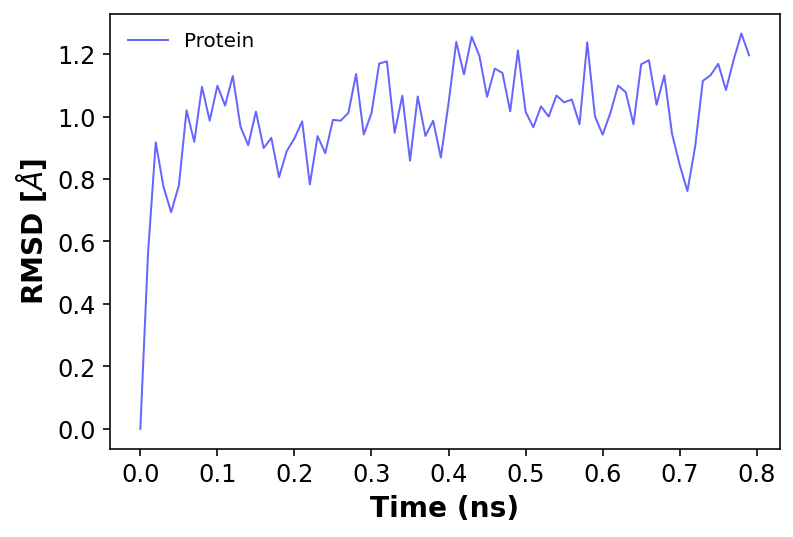

In [ ]:
#@title **Compute RMSD of protein's CA atoms**

#@markdown **Provide output file names below:** 
Output_name = 'rmsd_ca' #@param {type:"string"}


rmsd = pt.rmsd(traj_load, ref = 0, mask = "@CA")

# Smoothened Data:
#rmsd_smooth = smooth(rmsd, window = 'flat')

time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)
# Plotting:
plt.plot(time_array, rmsd, alpha=0.6, color = 'blue', linewidth = 1.0, label = 'Protein')

#plt.xlim(0, 900)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSD [$\AA$]", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon=False)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsd)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

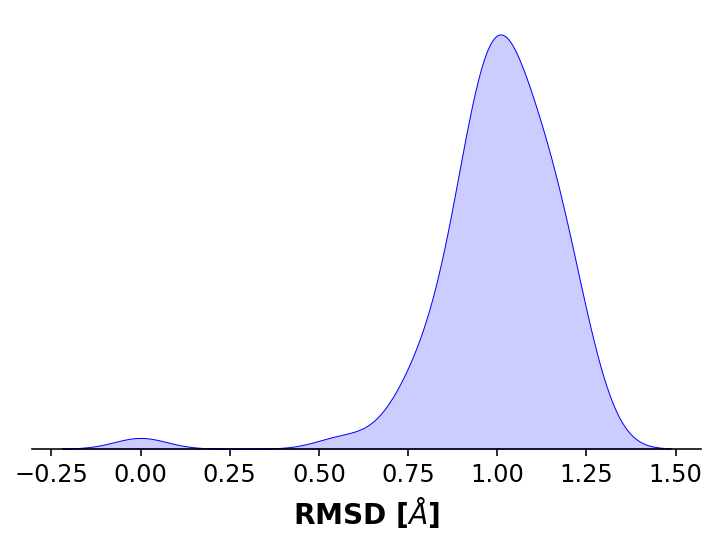

In [ ]:
#@title **Plot RMSD as a ditribution**

#@markdown **Provide output file names below:** 
Output_name = 'rmsd_dist' #@param {type:"string"}

ax = sb.kdeplot(rmsd, color="blue", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('RMSD [$\AA$]', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

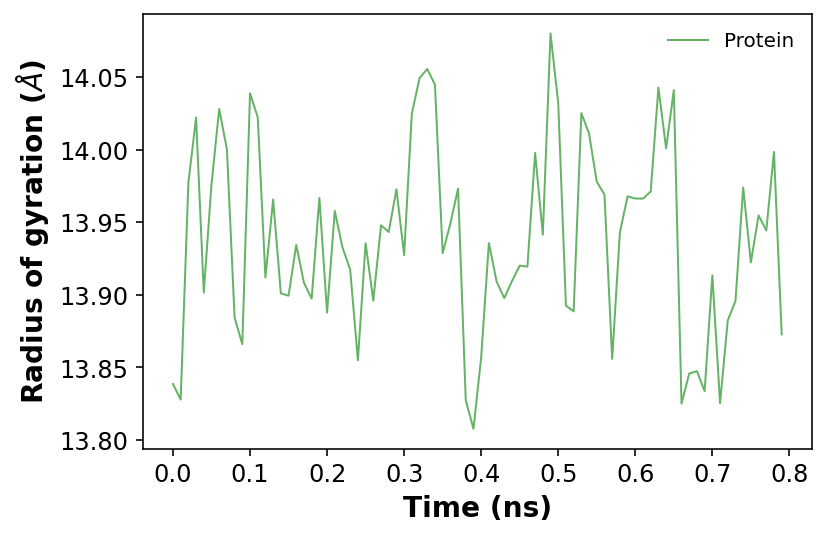

In [ ]:
#@title **Compute radius of gyration of protein's CA atoms**

#@markdown **Provide output file names below:** 
Output_name = 'radius_gyration' #@param {type:"string"}

radgyr = pt.radgyr(traj_load, mask = "@CA")
time = len(rmsd)*int(Write_the_trajectory)/1000
time_array = np.arange(0,time,int(Write_the_trajectory)/1000)

# Plotting:
plt.plot(time_array, radgyr, alpha=0.6, color = 'green', linewidth = 1.0, label = 'Protein')

#plt.xlim(0, 900)
#plt.ylim(2, 6)

plt.xlabel("Time (ns)", fontsize = 14, fontweight = 'bold')
plt.ylabel("Radius of gyration ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(frameon=False)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(radgyr)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

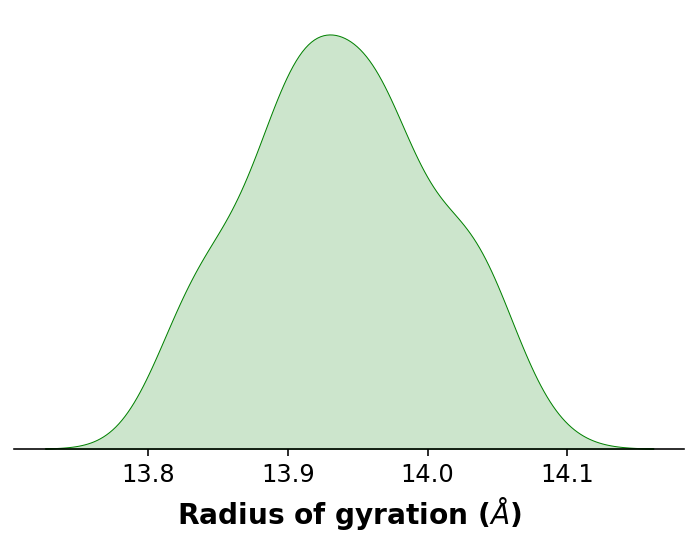

In [ ]:
#@title **Plot radius of gyration as a ditribution**

#@markdown **Provide output file names below:** 
Output_name = 'radius_gyration_dist' #@param {type:"string"}

ax = sb.kdeplot(radgyr, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('Radius of gyration ($\AA$)', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

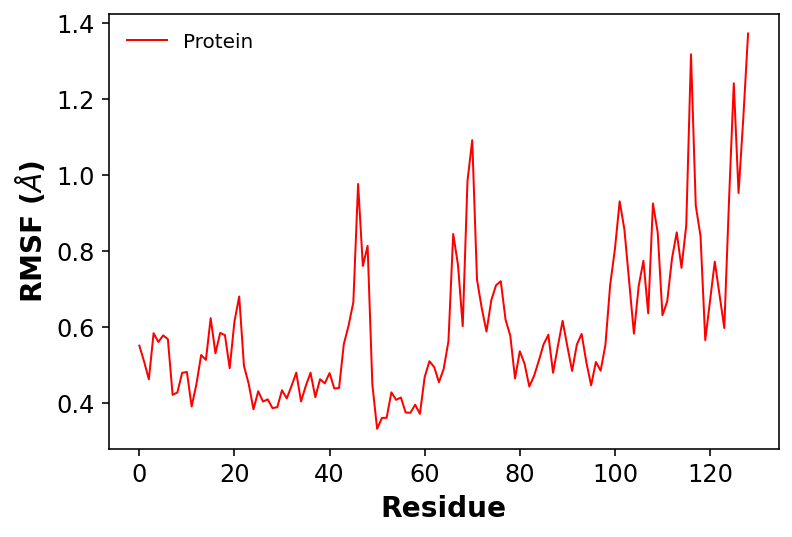

In [ ]:
#@title **Compute RMSF of protein's CA atoms**

#@markdown **Provide output file names below:** 
Output_name = 'rmsf_ca' #@param {type:"string"}


rmsf = pt.rmsf(traj_load, "@CA")
bfactor = pt.bfactors(traj_load, byres=True)

# Plotting:
plt.plot(rmsf[:,1], alpha=1.0, color = 'red', linewidth = 1.0, label = 'Protein')

plt.xlabel("Residue", fontsize = 14, fontweight = 'bold')
plt.ylabel("RMSF ($\AA$)", fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)

#plt.xticks(np.arange(min(rmsf[:1]), max(rmsf[:1])))
plt.yticks(fontsize = 12)
plt.legend(frameon=False)
plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(rmsf)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

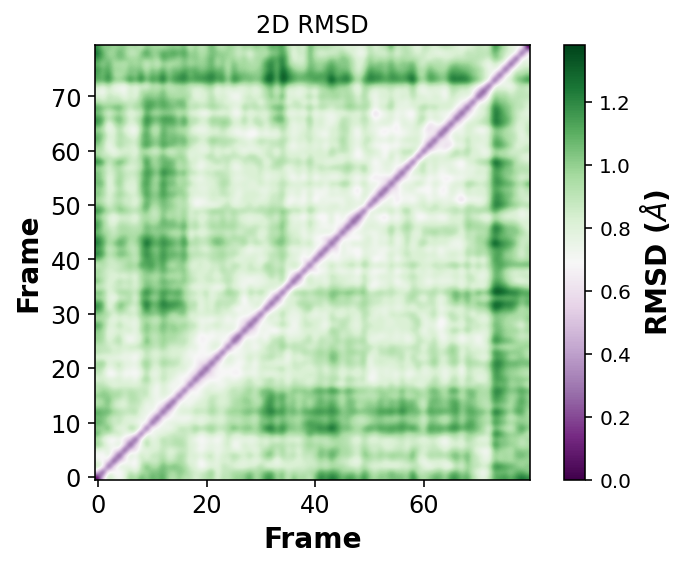

In [ ]:
#@title **2D RMSD**

#@markdown **Provide output file names below:** 
Output_name = '2D_rmsd' #@param {type:"string"}

simulation_time_analysis = float(stride_time_prod)*float(nstride)*1000
number_frames = int(simulation_time_analysis/float(Write_the_trajectory))

mat1 = pt.pairwise_rmsd(traj_load, mask="@CA*", frame_indices=range(number_frames))


plt.imshow(mat1, cmap = 'PRGn', origin='lower', interpolation = 'bicubic')
plt.title('2D RMSD')
plt.xlabel('Frame', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frame', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

cbar1 = plt.colorbar()
cbar1.set_label("RMSD ($\AA$)", fontsize = 14, fontweight = 'bold')


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat1)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))

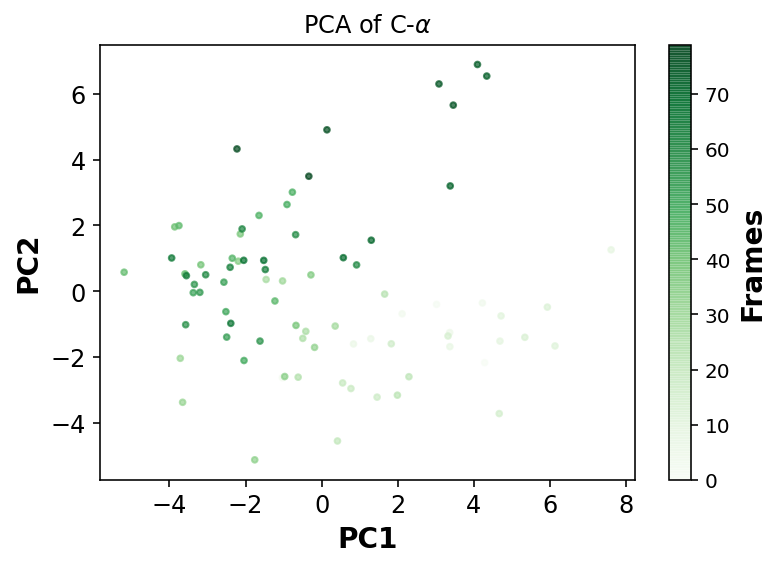

In [ ]:
#@title **Calculate eigvenctors of Principle Component Analysis (PCA)**
data = pt.pca(traj_load, fit=True, ref=0, mask='@CA', n_vecs=2)
#print('projection values of each frame to first mode = {} \n'.format(data[0][0]))
#print('projection values of each frame to second mode = {} \n'.format(data[0][1]))
#print('eigvenvalues of first two modes', data[1][0])
#print("")
#print('eigvenvectors of first two modes: \n', data[1][1])


#@markdown **Provide output file names below:** 
Output_name = 'PCA' #@param {type:"string"}

Output_PC1 = 'PC1' #@param {type:"string"}
Output_PC2 = 'PC2' #@param {type:"string"}

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # high resolution
projection_data = data[0]
plt.title(r'PCA of C-$\alpha$')
PC1 = data[0][0] 
PC2 = data[0][1]

a = plt.scatter(PC1,PC2, c=range(int(number_frames)), cmap='Greens', marker='o',s=8, alpha=0.7)

plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.ylabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar(a, orientation="vertical")
cbar1.set_label('Frames', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

pc1=pd.DataFrame(PC1)
pc1.to_csv(os.path.join(workDir, Output_PC1 + ".csv"))
pc2=pd.DataFrame(PC2)
pc2.to_csv(os.path.join(workDir, Output_PC2 + ".csv"))

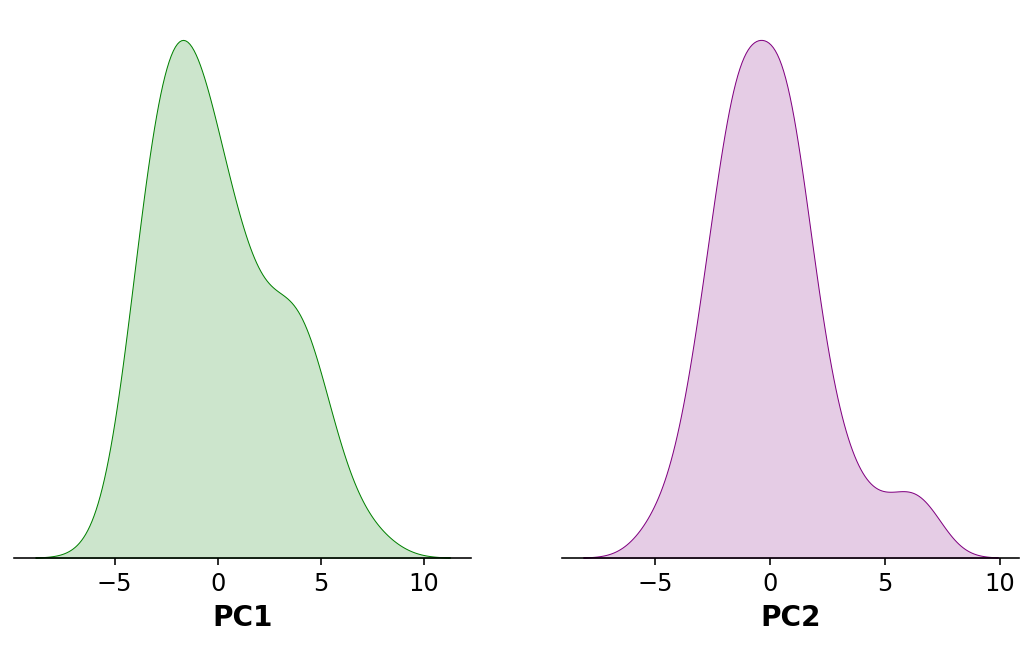

In [ ]:
#@title **Plot Principal Component 1 (PC1) and Principal Component 2 (PC2) as a ditribution**
Output_name = 'PCA_dist' #@param {type:"string"}


fig = plt.figure(figsize=(9,5))

plt.subplot(1, 2, 1)
ax = sb.kdeplot(PC1, color="green", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC1', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
plt.subplot(1, 2, 2)
ax2 = sb.kdeplot(PC2, color="purple", shade=True, alpha=0.2, linewidth=0.5)
plt.xlabel('PC2', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks([])
plt.ylabel('')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)


plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

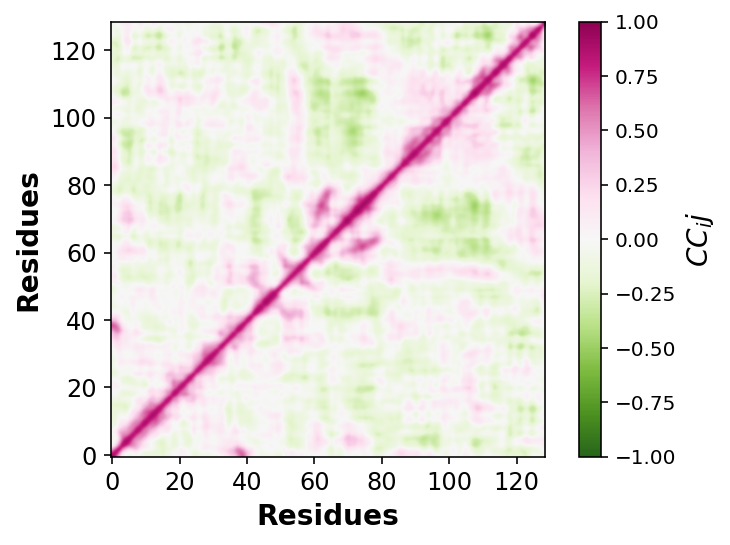

In [ ]:
#@title **Pearson's Cross Correlation (CC)**

#@markdown **Provide output file names below:** 
Output_name = 'cross_correlation' #@param {type:"string"}


traj_align = pt.align(traj_load, mask='@CA', ref=0)

mat_cc = matrix.correl(traj_align, '@CA')

ax = plt.imshow(mat_cc, cmap = 'PiYG_r', interpolation = 'bicubic', vmin = -1, vmax = 1, origin='lower')

plt.xlabel('Residues', fontsize = 14, fontweight = 'bold')
plt.ylabel('Residues', fontsize = 14, fontweight = 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
cbar1 = plt.colorbar()
cbar1.set_label('$CC_ij$', fontsize = 14, fontweight = 'bold')

plt.savefig(os.path.join(workDir, Output_name + ".png"), dpi=600, bbox_inches='tight')

raw_data=pd.DataFrame(mat_cc)
raw_data.to_csv(os.path.join(workDir, Output_name + ".csv"))